# Results request - CAZ_R performance on TESSy

In [1]:
import torch
import yaml
import wandb
import argparse
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
from torch.utils.data import Dataset, DataLoader

BASE_DIR = Path(os.path.abspath(''))
sys.path.append(str(BASE_DIR))
os.chdir(BASE_DIR)

# user-defined modules
from pheno.models import BERT

# user-defined functions
from utils import get_split_indices, export_results, get_average_and_std_df

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

In [2]:
config = yaml.safe_load(open("config_pheno.yaml"))
data_config = config['data']
defined_antibiotics = sorted(list(set(data_config['antibiotics']['abbr_to_names'].keys()) - set(data_config['exclude_antibiotics'])))
ab_to_idx = {ab: idx for idx, ab in enumerate(defined_antibiotics)}
specials = config['specials']
cls_token, pad_token, mask_token = specials['CLS'], specials['PAD'], specials['MASK']
max_seq_len = 19

In [3]:
ab_to_idx

{'AMK': 0,
 'AMP': 1,
 'CAZ': 2,
 'CIP': 3,
 'CRO': 4,
 'CTX': 5,
 'ETP': 6,
 'FEP': 7,
 'GEN': 8,
 'IPM': 9,
 'LVX': 10,
 'MEM': 11,
 'MFX': 12,
 'NAL': 13,
 'TOB': 14}

## Load and prepare dataset for inference

In [4]:
# ds_path = 'data/TESSy_15_all_pathogens.pkl'
ds_path = data_config['load_path']
ds_TESSy = pd.read_pickle(ds_path)
print(f"Total number of samples in TESSy: {len(ds_TESSy):,}")

Total number of samples in TESSy: 1,440,857


CAZ_R experiment

In [5]:
antibiotics = ['CAZ', 'CIP', 'AMP', 'GEN']
# antibiotics = ['CAZ', 'CIP', 'AMP', 'GEN', 'TZP']
ds_CAZ = ds_TESSy.copy()
ds_CAZ['phenotypes'] = ds_CAZ['phenotypes'].apply(lambda x: [p for p in x if p.split('_')[0] in antibiotics])
# ds_CAZ = ds_CAZ[ds_CAZ['phenotypes'].apply(lambda x: 'CAZ_R' in x)].reset_index(drop=True)
ds_CAZ = ds_CAZ[ds_CAZ['phenotypes'].apply(lambda x: all([ab in [p.split('_')[0] for p in x] for ab in antibiotics]))].reset_index(drop=True)
ds_CAZ.drop(columns=['num_R', 'num_S', 'num_ab'], inplace=True)
ds_CAZ = ds_CAZ.sample(frac=1, random_state=config['random_state']).reset_index(drop=True)
print(f"Number of selected samples: {len(ds_CAZ):,}")

Number of selected samples: 703,739


CIP_R experiment

In [6]:
antibiotics = ['CIP', 'AMP', 'CAZ', 'CTX', 'CRO', 'ETP', 'FEP']
ds_CIP = ds_TESSy.copy()
ds_CIP['phenotypes'] = ds_CIP['phenotypes'].apply(lambda x: [p for p in x if p.split('_')[0] in antibiotics])
# ds_CIP = ds_CIP[ds_CIP['phenotypes'].apply(lambda x: 'CIP_R' in x)].reset_index(drop=True)
ds_CIP = ds_CIP[ds_CIP['phenotypes'].apply(lambda x: all([ab in [p.split('_')[0] for p in x] for ab in antibiotics]))].reset_index(drop=True)
ds_CIP.drop(columns=['num_R', 'num_S', 'num_ab'], inplace=True)
ds_CIP = ds_CIP.sample(frac=1, random_state=config['random_state']).reset_index(drop=True)
print(f"Number of selected samples in ds_CIP: {len(ds_CIP):,}")

Number of selected samples in ds_CIP: 34,276


Prepare dataset

In [29]:
torch.cuda.empty_cache()
vocab_path = BASE_DIR / "pheno_vocab.pt" 
vocab = torch.load(vocab_path)

class MMInferenceDataset(Dataset):
    
    def __init__(self, ds, vocab, defined_antibiotics, max_seq_len, specials, selected_ab_idx, patient_info_only=False):
        self.ds = ds
        self.vocab = vocab
        self.max_seq_len = max_seq_len
        self.specials = specials
        self.CLS, self.PAD, self.MASK = specials['CLS'], specials['PAD'], specials['MASK']
        self.device = device
        self.ab = defined_antibiotics[selected_ab_idx]
        self.patient_info_only = patient_info_only
        
        self.phenotypes = self.ds['phenotypes'].tolist()
        self.year_col = self.ds['year'].astype(str).tolist()
        self.country_col = self.ds['country'].tolist()
        self.gender_col = self.ds['gender'].tolist()
        self.age_col = self.ds['age'].astype(int).astype(str).tolist()
        
        self.columns = ['indices_masked', 'attn_mask', 'target_res', 'masked_sequences']
        
    def prepare_dataset(self):
        masked_phenotypes = []
        target_res = []
        for phen_list in self.phenotypes:
            masked_phen_list = []
            for p in phen_list:
                if p.split('_')[0] != self.ab:
                    if self.patient_info_only:
                        pass
                    else:
                        masked_phen_list.append(p)
                else:
                    if p == self.ab+'_R':
                        target_res.append(1)
                    else:
                        target_res.append(0)
                    # masked_phen_list.append(p) ### TEMPORARY TEST - leaves what is to be predicted ####
                    masked_phen_list.append(self.MASK)
            masked_phenotypes.append(masked_phen_list)

        masked_sequences = [[specials['CLS'], self.year_col[i], self.country_col[i], self.gender_col[i], self.age_col[i]] + masked_phenotypes[i] for i in range(len(self.ds))]
        masked_sequences = [seq + [pad_token]*(max_seq_len-len(seq)) for seq in masked_sequences]
        indices_masked = [vocab.lookup_indices(masked_seq) for masked_seq in masked_sequences]
        attn_mask = [[False if token == pad_token else True for token in seq] for seq in masked_sequences]
        
        rows = zip(indices_masked, attn_mask, target_res, masked_sequences)
        self.df = pd.DataFrame(rows, columns=self.columns)
    
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        item = self.df.iloc[idx]
        
        input = torch.tensor(item['indices_masked'], dtype=torch.long, device=self.device)
        masked_sequences = item['masked_sequences']
        target_res = torch.tensor(item['target_res'], dtype=torch.float, device=self.device)
        attn_mask = (input != self.vocab[self.PAD]).unsqueeze(0).unsqueeze(1)
        
        return input, attn_mask, target_res

CAZ_idx = ab_to_idx['CAZ']
CIP_idx = ab_to_idx['CIP']
AMP_idx = ab_to_idx['AMP']
GEN_idx = ab_to_idx['GEN']
CTX_idx = ab_to_idx['CTX']

ds = ds_CAZ.copy()
num_samples = 40000
ab_idx = CAZ_idx

ds = ds_CIP.copy()
num_samples = len(ds_CIP)
ab_idx = CIP_idx

selected_ab = defined_antibiotics[ab_idx]
print("selected ab:", selected_ab)

patient_info_only = True

ds_inference = MMInferenceDataset(ds.iloc[:num_samples], vocab, defined_antibiotics, max_seq_len, specials, ab_idx, patient_info_only=patient_info_only)
inference_loader = DataLoader(ds_inference, batch_size=512, shuffle=False)

selected ab: CIP


## Load vocab & fine-tuned model

In [30]:
vocab_size = len(vocab)
## patient_data/patient_data+pheno
# model_name = '0.2'                                # dumb/dumb for CAZ, 0./0 for CIP
# model_name = '0.2_WL'                             # 0.30/0.53 for CAZ, 0.36/0.41 for CIP
# model_name = '0.4'                                # dumb/0.22 for CAZ, 0./0. for CIP
# model_name = '0.4_WL'                             # 0.01/0.48 for CAZ, 0./0. for CIP
# model_name = '0.4_strong_WL'                      # dumb/0.49 for CAZ, 0./0. for CIP
# model_name = '0.8'                                # dumb/dumb for CAZ, 0./0. for CIP
# model_name = '0.8_WL'                             # dumb/0.05 for CAZ, 0./0. for CIP
# model_name = '2known_WL'                          # 0.05/0.44 for CAZ, 0./0. for CIP
# model_name = '2known_lr1e-5_WL'                   # 0.02/0.44 for CAZ, 0./0. for CIP
# model_name = '0.2_BERT_WL'                        # 0.0,0.40 for CAZ, 0.24,0.44 for CIP
# model_name = '0.8_BERT_WL'                        # 0.0,0.45 for CAZ, 0.29,0.50 for CIP
################################ Revamped masking ##################################
# model_name = '0.2_MASK_WL'                        # 0.0,0.44 for CAZ, 0.34,0.53 for CIP
# model_name = '0.8_MASK_WL'                        # 0.0,0.43 for CAZ, 0.13,0.43 for CIP

# model_name = 'mask_exp_0.2_BERT_WL'               # 0.0,0.67 for CAZ, 0.42,0.62 for CIP
# model_name = 'mask_exp_0.2_MASK_WL'               # 0.0,0.54 for CAZ, 0.16,0.44 for CIP
# model_name = 'mask_exp_0.2_0.1same_WL'            # 0.0,0.38 for CAZ, 0.11,0.55 for CIP
# model_name = 'mask_exp_0.2_0.05same_WL'           # 0.0,0.37 for CAZ, 0.11,0.54 for CIP

# model_name = 'mask_exp_0.8_BERT_WL'               # 0.02,0.54 for CAZ, 0.41,0.58 for CIP
# model_name = 'mask_exp_0.8_MASK_WL'               # 0.01,0.48 for CAZ, 0.31,0.58 for CIP
# model_name = 'mask_exp_0.8_0.1same_WL'            # 0.0,0.44 for CAZ, 0.28,0.46 for CIP
# model_name = 'mask_exp_0.8_0.05same_WL'           # 0.0,0.62 for CAZ, 0.42,0.50 for CIP

################################ New models ##################################
# model_name = 'easyCPT'                            # 0.02,0.22 for CAZ, 0.10,0.0.40 for CIP
# model_name = 'mediumCPT'                          # 0.0,0.14 for CAZ, 0.03,0.41 for CIP
# model_name = 'hardCPT'                            # 0.0,0.0 for CAZ, 0.0,0.41 for CIP
# model_name = 'easyRPT'                            # 0.02,0.28 for CAZ, 0.0,0.40 for CIP
# model_name = 'mediumRPT'                          # 0.00,0.35 for CAZ, 0.04,0.40 for CIP
# model_name = 'hardRPT'                            # 0.00,0.29 for CAZ, 0.001,0.41 for CIP
################################ New models [WL] ##################################
# model_name = 'super_easyCPT_WL'                   # 0.05,0.51 for CAZ, 0.46,0.52 for CIP
# model_name = 'super_easyCPT_strong_WL'            # 0.04,0.62 for CAZ, (0.67),0.64 for CIP
# model_name = 'easyCPT_WL'                         # 0.04,0.44 for CAZ, 0.22,0.50 for CIP
# model_name = 'mediumRPT_WL'                       # 0.00,0.40 for CAZ, 0.32,0.62 for CIP

model_path = f'results/pheno/{model_name}/model_state.pt'

num_ab = 15
dim = 512
config['emb_dim'] = dim
config['ff_dim'] = dim
config['hidden_dim'] = dim

bert = BERT(
    config,
    vocab_size=vocab_size,
    max_seq_len=max_seq_len,
    num_ab=num_ab,
    pad_idx=vocab[pad_token],
).to(device)
print("selected ab", selected_ab)
# print("Randomly initialized model:")
# print(bert.classification_layer[ab_idx].state_dict()['classifier.3.weight'])
# print(bert.classification_layer[ab_idx].state_dict()['classifier.3.bias'])
# print("Saved model:")
# print(torch.load(model_path)['ab_predictors'][ab_idx]['classifier.3.weight'])
# print(torch.load(model_path)['ab_predictors'][ab_idx]['classifier.3.bias'])
bert.load_state_dict(torch.load(model_path))

selected ab CIP


<All keys matched successfully>

In [31]:
print("Model:", model_name)
results = pd.read_pickle('results/pheno/'+model_name+'/results.pkl')
print("selected ab:", selected_ab)
results.keys()
results['ab_stats'].set_index('antibiotic').loc[selected_ab]

Model: easyCPT
selected ab: CIP


num_tot          41958.000000
num_S            33358.000000
num_R             8600.000000
num_pred_S       37057.000000
num_pred_R        4901.000000
num_correct      36271.000000
num_correct_S    32364.000000
num_correct_R     3907.000000
accuracy             0.864460
sensitivity          0.454302
specificity          0.970202
precision            0.797184
F1                   0.578772
Name: CIP, dtype: float64

## Main process

In [32]:
with torch.no_grad():
    bert.eval()
    # ds = ds_inference_NCBI
    # loader = inference_loader_NCBI  
    ds = ds_inference
    loader = inference_loader
    ds.prepare_dataset()
    print("selected ab:", selected_ab)
    print("Number of samples in inference dataset:", len(ds))
    print("Number of batches in inference loader:", len(loader))
    print("="*50)
    tot_num_S, tot_num_R = 0, 0
    tot_correct, tot_num_correct_S, tot_num_correct_R = 0, 0, 0
    tot_num_pred_S, tot_num_pred_R = 0, 0
    pred_sigmoids = torch.tensor([]).to(device)
    targets = torch.tensor([]).to(device)
    for input, attn_mask, target_res in loader:
        pred_logits = bert(input, attn_mask)
        pred_res = torch.where(pred_logits > 0, torch.ones_like(pred_logits), torch.zeros_like(pred_logits))
        pred_sigmoids = torch.cat((pred_sigmoids, torch.sigmoid(pred_logits[:, ab_idx])))
        targets = torch.cat((targets, target_res))
        ab_preds = pred_res[:, ab_idx]
        num_R_pred = ab_preds.sum().item()
        tot_num_pred_R += num_R_pred
        num_S_pred = ab_preds.shape[0] - num_R_pred
        tot_num_pred_S += num_S_pred 
            
        num_S = target_res.eq(0).sum().item()
        tot_num_S += num_S
        num_R = target_res.eq(1).sum().item()
        tot_num_R += num_R
        
        eq = torch.eq(pred_res[:, ab_idx], target_res)
        num_correct = eq.sum().item()
        tot_correct += num_correct
        num_correct_R = eq[target_res == 1].sum().item()
        tot_num_correct_R += num_correct_R
        num_correct_S = eq[target_res == 0].sum().item()
        tot_num_correct_S += num_correct_S
        num_R_pred = pred_res[:, ab_idx].sum().item()
    print(f"Total {selected_ab} accuracy: {tot_correct/(tot_num_S+tot_num_R):.4f}")
    print(f"Data imbalance (R_share) of {selected_ab}: {tot_num_R/(tot_num_S+tot_num_R):.4f}")
    print(f"Share of predictions that were {selected_ab}_R: {tot_num_pred_R/(tot_num_S+tot_num_R):.4f}")
    print(f"Share of predictions that were {selected_ab}_S: {tot_num_pred_S/(tot_num_S+tot_num_R):.4f}")
    print(f"Total {selected_ab}_R accuracy: {tot_num_correct_R/tot_num_R:.4f}")
    if tot_num_pred_R > 0:
        print(f"Precision: {tot_num_correct_R/tot_num_pred_R:.4f}")
    print(f"Total {selected_ab}_S accuracy: {tot_num_correct_S/tot_num_S:.4f}")

selected ab: CIP
Number of samples in inference dataset: 34276
Number of batches in inference loader: 67
Total CIP accuracy: 0.7562
Data imbalance (R_share) of CIP: 0.2211
Share of predictions that were CIP_R: 0.0657
Share of predictions that were CIP_S: 0.9343
Total CIP_R accuracy: 0.0974
Precision: 0.3276
Total CIP_S accuracy: 0.9432


In [33]:
fpr, tpr, thresholds = roc_curve(targets.cpu().numpy(), pred_sigmoids.cpu().numpy())
auc_score = auc(fpr, tpr)
print(f"AUC: {auc_score:.4f}")
best_index = np.argmax(tpr-fpr)
best_threshold = thresholds[best_index]
fpr_best, tpr_best = fpr[best_index], tpr[best_index]
fdr= fpr_best/(fpr_best+tpr_best)
print(f"Best threshold: {best_threshold:.4f}")
print(f"At best, TPR: {tpr[best_index]:.4f}, with FPR: {fpr[best_index]:.4f} and FDR: {fdr:.4f}")

AUC: 0.5900
Best threshold: 0.1809
At best, TPR: 0.6007, with FPR: 0.4599 and FDR: 0.4336


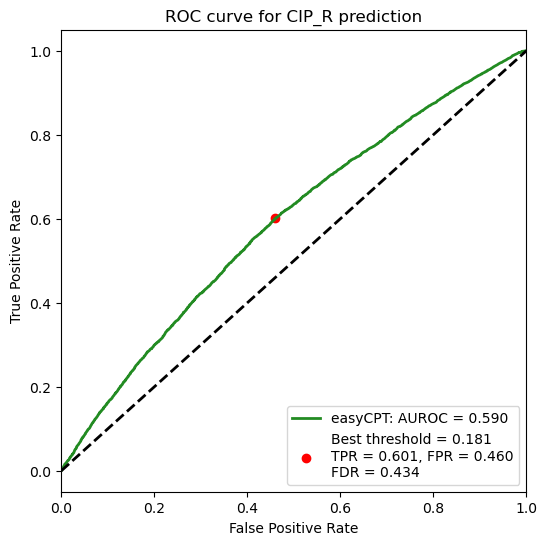

In [34]:
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='forestgreen', lw=2, label=f'{model_name}: AUROC = {auc_score:.3f}')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
label = f'Best threshold = {best_threshold:.3f}\nTPR = {tpr_best:.3f}, FPR = {fpr_best:.3f}\nFDR = {fdr:.3f}'
plt.scatter(fpr_best, tpr_best, color='red', label=label)
plt.xlim([0.0, 1.0])
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC curve for {selected_ab}_R prediction')
plt.show()

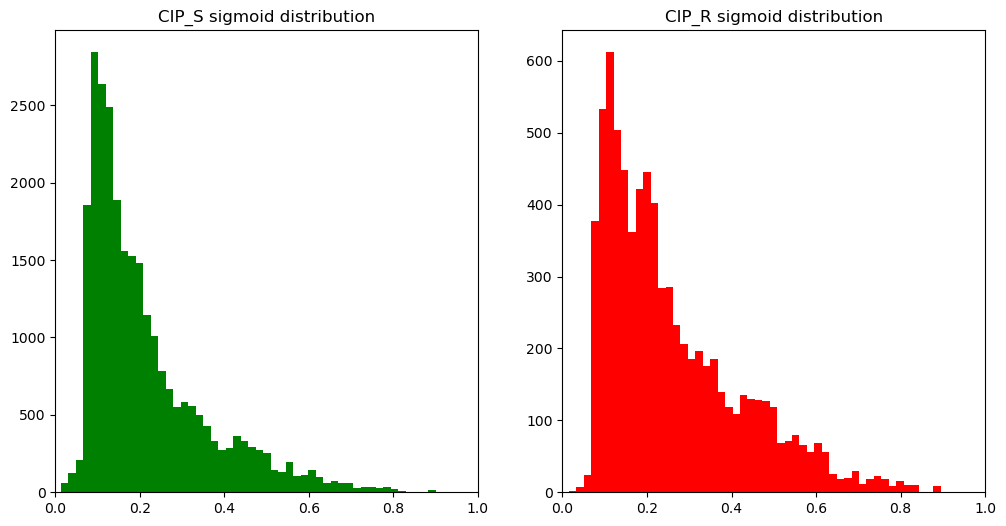

In [35]:
pred_sigmoids_np = pred_sigmoids.cpu().numpy()
targets_np = targets.cpu().numpy()
pred_sigmoids_R = pred_sigmoids_np[targets_np == 1]
pred_sigmoids_S = pred_sigmoids_np[targets_np == 0]
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].hist(pred_sigmoids_S, bins=50, color='green', label=f'{selected_ab}_S')
axes[0].set_title(f'{selected_ab}_S sigmoid distribution')
axes[0].set_xlim(0, 1)
axes[1].hist(pred_sigmoids_R, bins=50, color='red', label=f'{selected_ab}_R')
axes[1].set_title(f'{selected_ab}_R sigmoid distribution')
axes[1].set_xlim(0, 1)
plt.show()